In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [60]:
!ls ../data2/

DK55_premotor_manual_2021-12-09.csv
DK55_premotor_manual_negative_round1_2021-12-09.csv
DK55_premotor_manual_positive_round1_2021-12-09.csv
DK55_premotor_sure_detection_2021-12-09.csv
DK55_premotor_unsure_detection_2021-12-09.csv


In [3]:
file={'manual_train':'../data2/DK55_premotor_manual_2021-12-09.csv',
      'manual_negative':'../data2/DK55_premotor_manual_negative_round1_2021-12-09.csv',
      'manual_positive':'../data2/DK55_premotor_manual_positive_round1_2021-12-09.csv',
      'computer_sure':'../data2/DK55_premotor_sure_detection_2021-12-09.csv',
      'computer_unsure':'../data2/DK55_premotor_unsure_detection_2021-12-09.csv'
     }

In [4]:
dfs={}
for name,path in file.items():
    dfs[name]= pd.read_csv(path,header=None)
    dfs[name]['name']=name

In [5]:
dfs.keys()

dict_keys(['manual_train', 'manual_negative', 'manual_positive', 'computer_sure', 'computer_unsure'])

In [6]:
All=pd.concat([dfs[key] for key in dfs])

In [7]:
All.shape,[(key,dfs[key].shape) for key in dfs]

((16813, 4),
 [('manual_train', (1912, 4)),
  ('manual_negative', (364, 4)),
  ('manual_positive', (893, 4)),
  ('computer_sure', (12224, 4)),
  ('computer_unsure', (1420, 4))])

In [8]:
All.columns=['x','y','section','name']
All['x']=np.floor(All['x'])
All['y']=np.floor(All['y'])
All.iloc[:10,:]

,x,y,section,name
0,36418.0,19700.0,124.0,manual_train
1,36386.0,19514.0,124.0,manual_train
2,41504.0,14066.0,128.0,manual_train
3,41209.0,14259.0,136.0,manual_train
4,41190.0,14322.0,136.0,manual_train
5,41354.0,14395.0,136.0,manual_train
6,38170.0,17708.0,136.0,manual_train
7,41334.0,14627.0,140.0,manual_train
8,41303.0,14869.0,140.0,manual_train
9,41516.0,14706.0,140.0,manual_train


In [9]:
%%time
# Compute all pairwise distances

from scipy.spatial import distance_matrix
#make distances between sections very large
All['section']*=1000
Distances=distance_matrix(np.array(All.iloc[:,:3]),np.array(All.iloc[:,:3]))
All['section']/=1000

CPU times: user 4.43 s, sys: 5.96 s, total: 10.4 s
Wall time: 3.14 s


In [10]:
small_distances=Distances[Distances<200]
small_distances=small_distances[small_distances>0]
small_distances.shape

(27574,)

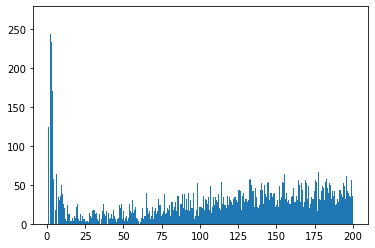

In [11]:
hist(small_distances,bins=1000);

In [12]:
very_small=Distances<30

In [13]:
pairs=np.transpose(np.nonzero(very_small))
pairs.shape

(22615, 2)

In [14]:
pairs=pairs[pairs[:,0]< pairs[:,1],:]
pairs.shape

(2901, 2)

In [15]:
All.shape

(16813, 4)

In [16]:
names=list(All.iloc[:,-1])

In [17]:
def append_all(A,B):
    for b in B:
        if not b in A:
            A.append(b)
    B=A
    return A,B

In [18]:
%%time
sets={} #an indexed set of hashes
for i in range(All.shape[0]):
    sets[i]=[i]
max_index=0
len(sets)

for i in range(pairs.shape[0]):
    first,second=pairs[i]
    sets[first],sets[second]=append_all(sets[first],sets[second])


CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 14.3 ms


In [19]:
#remove set duplicates

print('before removing duplicates',len(sets))
for i in range(len(sets)):
    if not i in sets:
        continue
    for j in sets[i]:
        if j != i and j in sets:
            del sets[j]
print('after removing duplicates',len(sets))

before removing duplicates 16813
after removing duplicates 14106


In [20]:
set_names={}
for key in sets:
    set_names[key]=[names[i] for i in sets[key]]
list(set_names.items())[:5]

[(0, ['manual_train', 'computer_sure']),
 (1, ['manual_train', 'computer_sure']),
 (2, ['manual_train', 'computer_sure']),
 (3, ['manual_train']),
 (4, ['manual_train', 'computer_sure'])]

### Analysis with respect to originally labeled sections

In [21]:
#find sections used for training
sections=[]
for i in range(All.shape[0]):
    if All.iloc[i,3]=='manual_train':
        #print(int(All.iloc[i,2]))
        sections.append(int(All.iloc[i,2]))
sections=unique(sections)
sections

array([124, 128, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176,
       180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228,
       232, 236, 240, 244, 248, 252])

In [22]:
def check(L,yes=None,no=None,size_min=None,size_max=None):
    """ Return true if names in yes appear in L, names in no do not appear, 
        and the length of the list is between min_size and max_size"""

    if not yes is None:
        for e in yes:
            if not e in L:
                return False
            
    if not no is None:
        for e in no:
            if e in L:
                return False
    
    if not size_min is None:
            if len(L)<size_min:
                return False
            
    if not size_max is None:
            if len(L)>size_max:
                return False

    return True


In [23]:
train_sections={}

In [24]:
## Cells detected in train by computer
count=0
for i in sets:
    if int(All.iloc[i,2]) in sections:
        if set_names[i]==['computer_sure']:
            #print(sets[i],set_names[i])
            count+=1
train_sections['Computer Detected in train sections, Human Missed']=count
train_sections

{'Computer Detected in train sections, Human Missed': 57}

In [25]:
# total number of cells in training set
count=0
for i in sets:
        if int(All.iloc[i,2]) in sections:
            if 'manual_train' in set_names[i]:
                count+=1
train_sections['total train']=count
train_sections

{'Computer Detected in train sections, Human Missed': 57, 'total train': 1882}

In [26]:
contra=[]
count=0
for i in sets:
    if int(All.iloc[i,2]) in sections:
        if check(set_names[i],yes=['manual_negative','manual_train']):
            for j in sets[i]:
                contra.append(j)
            count+=1
train_sections['Human mind change']=count
train_sections

{'Computer Detected in train sections, Human Missed': 57,
 'total train': 1882,
 'Human mind change': 32}

## Analysis of all sections

In [27]:
test_counts={}

In [49]:
dict(All.iloc[i,:])

{'x': 38225.0, 'y': 17669.0, 'section': 153.0, 'name': 'manual_positive'}

In [52]:
# undetected by computer but marked positive by human
count=0
computer_missed_indexes=[]
for i in sets:
    if  check(set_names[i],yes=['manual_positive'],no=['computer_sure','computer_unsure'],size_max=1):
        computer_missed_indexes.append((i,dict(All.iloc[i,:])))
        count+=1
test_counts['computer missed, human detected']=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401,
 'Total computer as UNsure': 1285,
 'Total computer as UNsure, unmarked by human': 633,
 'detected by computer as sure, unmarked by human': 10558,
 'More than 2 labels (excluding train)': 26}

In [58]:
import pickle as pk
pk.dump(computer_missed_indexes,open('computerMissed.pkl','wb'))
!ls -l computerMissed.pkl

-rw-r--r-- 1 yfreund freund 23010 Jan  4 18:48 computerMissed.pkl


In [59]:
label="detected by computer as sure, marked by human as negative"
count=0
for i in sets:
    if  check(set_names[i],yes=['computer_sure','manual_negative'],size_max=2):
            count+=1
test_counts[label]=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401,
 'Total computer as UNsure': 1285,
 'Total computer as UNsure, unmarked by human': 633,
 'detected by computer as sure, unmarked by human': 10558,
 'More than 2 labels (excluding train)': 26}

In [30]:
label="detected by computer as UNsure, marked by human as negative"
count=0
for i in sets:
    if  check(set_names[i],yes=['computer_unsure','manual_negative'],size_max=2):
            count+=1
test_counts[label]=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248}

In [31]:
label="detected by computer as UNsure, marked by human as positive"
count=0
for i in sets:
    if  check(set_names[i],yes=['computer_unsure','manual_positive'],size_max=2):
            count+=1
test_counts[label]=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401}

In [32]:
label="Total computer as UNsure"
count=0
for i in sets:
    if  check(set_names[i],yes=['computer_unsure'],size_max=2):
            count+=1
test_counts[label]=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401,
 'Total computer as UNsure': 1285}

In [33]:
label="Total computer as UNsure, unmarked by human"
count=0
for i in sets:
    if  check(set_names[i],yes=['computer_unsure'],size_max=1):
            count+=1
test_counts[label]=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401,
 'Total computer as UNsure': 1285,
 'Total computer as UNsure, unmarked by human': 633}

In [34]:
label="detected by computer as sure, unmarked by human"
count=0
for i in sets:
    if  check(set_names[i],yes=['computer_sure'],size_max=1):
            count+=1
test_counts[label]=count
test_counts

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401,
 'Total computer as UNsure': 1285,
 'Total computer as UNsure, unmarked by human': 633,
 'detected by computer as sure, unmarked by human': 10558}

In [35]:
label="More than 2 labels (excluding train)"
count=0
for i in sets:
    if  check(set_names[i],no=['manual_train'],size_min=3):
        print(set_names[i])
        count+=1
test_counts[label]=count
test_counts

['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'computer_unsure', 'computer_unsure']
['manual_negative', 'manual_positive', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsure']
['manual_negative', 'manual_negative', 'computer_unsu

{'computer missed, human detected': 301,
 'detected by computer as sure, marked by human as negative': 50,
 'detected by computer as UNsure, marked by human as negative': 248,
 'detected by computer as UNsure, marked by human as positive': 401,
 'Total computer as UNsure': 1285,
 'Total computer as UNsure, unmarked by human': 633,
 'detected by computer as sure, unmarked by human': 10558,
 'More than 2 labels (excluding train)': 26}

In [36]:
train_sections, test_counts

({'Computer Detected in train sections, Human Missed': 57,
  'total train': 1882,
  'Human mind change': 32},
 {'computer missed, human detected': 301,
  'detected by computer as sure, marked by human as negative': 50,
  'detected by computer as UNsure, marked by human as negative': 248,
  'detected by computer as UNsure, marked by human as positive': 401,
  'Total computer as UNsure': 1285,
  'Total computer as UNsure, unmarked by human': 633,
  'detected by computer as sure, unmarked by human': 10558,
  'More than 2 labels (excluding train)': 26})